# 算法说明

## 算法1

Step1:

获取每月的因子溢价

Step2:

获取股票（举例：格力电器）的每月收益率

优化：收集多期的市场收益率、股票收益率，通过多期数据的回归，计算出$\alpha，\beta$，最终以$\alpha + \epsilon$ 来进行最终的回归

Ste3：

每月收益率为Y,因子溢价为X，求$\beta$
$$Y = \beta_{i} * X$$
下标i表示对应的股票，每个股票对应一个i，**说明对不同的股票对应因子溢价有不同的反应，最终的$\beta$矩阵记录了不同股票对不同因子溢价的响应值**

目前如果用ols，感觉只能一个股票一个股票进行OLS回归计算响应值，无法一次生成一个矩阵进行计算

step4:

预测：通过回归得到的$\beta$矩阵，适当预测因子溢价X，预测出Y

因子溢价X的预测方案：
1. 保持不变
2. 通过ARMA预测
3. 其他预测方法

## 算法2
$$E(r_{i}) = \beta_{i} * E(f) $$

$$V(r_{i}) = \beta_{i} * E(f) * \beta_{i} + V(\epsilon) $$

策略：

选取均值较高，方差较小的股票长期持仓


In [3]:
import numpy as np
import pandas as pd
from scipy import stats


import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl



# 引入Kalman函数库
from pykalman import KalmanFilter

# 引入纯随机序列检测，只有是非纯随机序列，才能进行检测
from statsmodels.stats.diagnostic import acorr_ljungbox

# 引入时序分析模型进行模型匹配
from statsmodels.tsa.arima_model import ARMA

import itertools

In [126]:
# 测试的股票列表
sec_pool = ['000651.XSHE',    # 格力电器
            '002597.XSHE',    # 金禾实业
            '000895.XSHE',    # 双汇发展
            '000002.XSHE',    # 万科A
            '601939.XSHG',    # 建设银行
            '002466.XSHE',    # 天齐锂业
            '002001.XSHE',    # 新和成
            '600660.XSHG',    # 福耀玻璃
            '000636.XSHE',    # 风华高科
            '600887.XSHG',    # 伊利股份
            '601238.XSHG'     # 广汽集团
            ]

sec = sec_pool[0]

In [127]:
startDate='2008-01-01'
endDate='2018-11-30'

sec_price = get_price(sec, start_date = startDate, end_date= endDate, frequency='1d', fields='close',fq = "none")['close']
sec_yield = sec_price/sec_price.shift(1)
sec_yield = sec_yield.fillna(1)


market_price = get_price('000300.XSHG', start_date = startDate, end_date= endDate, frequency='1d', fields='close',fq = "none")['close']
market_yield = market_price/market_price.shift(1)
market_yield = market_yield.fillna(1)


In [128]:
sec_yield_pd = pd.DataFrame()
sec_yield_pd['yield_rate'] = sec_yield
sec_yield_pd['yield_rate_log'] = np.log(sec_yield_pd['yield_rate'])
sec_yield_pd['month'] = np.array([d.strftime('%Y-%m') for d in sec_yield.index])

sec_yield_pd['yield_rate_market'] = market_yield
sec_yield_pd['yield_rate_market_log'] = np.log(sec_yield_pd['yield_rate_market'])


In [129]:
sec_yield_pd.shape

(2657, 5)

In [130]:
sec_yield_by_month_pd = pd.DataFrame(pd.DataFrame(index = sec_yield_pd.groupby('month')['yield_rate_log'].sum().index))
# sec_yield_by_month_pd.index = sec_yield_pd.groupby('date')['yield_rate_log'].sum().index
sec_yield_by_month_pd['yield_rate'] = np.exp(sec_yield_pd.groupby('month')['yield_rate_log'].sum())

sec_yield_by_month_pd['yield_rate_market'] = np.exp(sec_yield_pd.groupby('month')['yield_rate_market_log'].sum())


sec_yield_by_month_pd


,yield_rate,yield_rate_market
month,,
2008-01,1.069632,0.857997
2008-02,0.974684,1.011720
2008-03,0.832839,0.810887
2008-04,1.078414,1.044477
2008-05,0.844660,0.912155
2008-06,0.765468,0.773073
2008-07,0.663259,1.004796
2008-08,0.867052,0.852571
2008-09,1.033333,0.938126


In [132]:
y = np.array(sec_yield_by_month_pd['yield_rate'])

y = np.array(sec_yield_by_month_pd['yield_rate'] - sec_yield_by_month_pd['yield_rate_market'])
y.shape



(131,)

In [133]:
factor_pd = pd.concat(
                [pd.read_csv("result_factor_pd_by_month_no_reverse.csv",index_col=0),
                pd.read_csv("result_factor_pd_by_month_reverse.csv",index_col=0)] ,
                axis = 1)
            

In [134]:
factor_pd.shape

(131, 29)

In [ ]:
factor_pd = pd.concat([factor_pd,])

In [143]:
factor_pool = ['pb_ratio','pe_ratio_lyr','market_cap',
               'inc_return','turnover_ratio','gross_profit_margin',
               'expense_to_total_revenue','inc_total_revenue_annual',
               'inc_net_profit_year_on_year']


# factor_pool = ['pe_ratio_lyr','inc_net_profit_year_on_year']

In [144]:
x = [list(factor_pd[factor_pool].iloc[i,:]) for i in range(0,factor_pd.shape[0])]
X = sm.add_constant(x)

In [145]:
X.shape

(131, 10)

In [146]:
X.shape

(131, 10)

In [147]:
y.shape

(131,)

In [148]:
model = sm.OLS(y,X)
results = model.fit()

In [149]:
print(results.params)


[0.0035464267468481286 -0.21683846977619392 -0.19371130463462918
 0.06041636083038715 -0.494683882307954 -0.4994048569015723
 0.1318071144354372 0.0010507582324645586 -0.04662297057978094
 0.01233334504047003]


In [150]:
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.193
Date:                Sat, 20 Jul 2019   Prob (F-statistic):              0.305
Time:                        18:13:20   Log-Likelihood:                 111.97
No. Observations:                 131   AIC:                            -203.9
Df Residuals:                     121   BIC:                            -175.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.010      0.369      0.7

In [28]:
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.476
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     38.45
Date:                Sat, 20 Jul 2019   Prob (F-statistic):           9.54e-18
Time:                        17:32:33   Log-Likelihood:                 174.01
No. Observations:                 131   AIC:                            -340.0
Df Residuals:                     127   BIC:                            -328.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9892      0.006    170.679      0.0

# 观察因子序列

In [4]:
import statsmodels.tsa.stattools as ts

from datetime import datetime


# S1为自变量，S2为因变量
def kalman_beta(S1,S2):
    
    # 观察矩阵
    # 注意：
    # 1、观察到的是sec1数据，sec1是自变量x，sec2是因变量y
    # 2、需要使用add_constant来模拟alpha
    # 3、需要使用np.newaxis来增加维度
    obs_mat = sm.add_constant(S1.values, prepend=False)[:, np.newaxis]

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
                  initial_state_mean=np.ones(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),  # 不发生变化，都是单位矩阵
                  observation_matrices=obs_mat,   # 观察矩阵
                  observation_covariance=10**2,
                  transition_covariance=0.01**2 * np.eye(2))
    
    # 相当于使用sec2来进行训练，模拟出beta、alpha
    state_means, state_covs = kf.filter(S2[:, np.newaxis])
    
    # 第一个参数为beta，第二个参数为alpha
    return state_means[-1]

# 函数名：Cadf_test
# 输入参数：
# 1、res_pd:pandas数组，index为日期，列名为“res”
# 输出参数：
# P value：返回test的p值，用于后续监测
# null hypothesis of the Augmented Dickey-Fuller is that there is a unit root

def Cadf_test(res):

    # 使用adf计算adf的值
    cadf = ts.adfuller(res)
    
    return cadf[1]


# 重要：只有时间序列不是一个白噪声（纯随机序列）的时候，该序列才可做分析
# 函数名：test_stochastic
# 输入参数：
# 1、res_pd:pandas数组，index为日期，列名为“res”
# 输出参数：
# P value：返回test的p值，用于后续监测
# Ljung-Box test for no autocorrelation
# 纯随机性检验,p值小于5%,序列为非白噪声
# H0: 原本的数据都是纯随机序列
# 用于检验某个时间段内的一系列观测值是不是随机的独立观测值
# 如果观测值并非彼此独立，一个观测值可能会在 i 个时间单位后与另一个观测值相关，形成一种称为自相关的关系
# 自相关可以削减基于时间的预测模型（例如时间序列图）的准确性，并导致数据的错误解释。

def test_stochastic(ts):
    p_value = acorr_ljungbox(ts)[1] #lags可自定义
    return p_value[0]



def position_generate(buy_list,sell_list):
    # 生成混合序列
    combine_list = np.array(buy_list) + np.array(sell_list)


    # 生成状态序列
    state_list = []
    # 1、初始化第一个状态，如果是0则设置为-1，如果是-1则保持-1，如果是1则保持1
    if combine_list[0] == 0:
        state_list.append(-1)
    else:
        state_list.append(combine_list[0])

    # 2、开始设置后续的状态，如果是0则设置为前一个状态，如果当前状态与前一个状态不同，则设置为当前状态
    for state in combine_list[1:]:
        if state == 0:
            state_list.append(state_list[-1])
        else:
            state_list.append(state)

    # 进行异或操作
    xor_list = []
    for i in range(len(state_list)):
        if state_list[i] == np.array(pd.Series(state_list).shift(1).fillna(-1))[i]:
            xor_list.append(0)
        else:
            xor_list.append(1)

    # 生成新的买入、卖出数组
    buy_point_new = np.array(buy_list) * xor_list
    sell_point_new = np.array(sell_list) * xor_list

    # 生成新的混合数组
    combine_list_new = buy_point_new + sell_point_new

    return np.cumsum(combine_list_new)

In [5]:
observe_pd = pd.read_csv("result_factor_pd_by_month_reverse.csv",index_col=0)

In [6]:
observe_pd.index = [datetime.strptime(d,'%Y-%m') for d in observe_pd.index]
observe_pd

,pe_ratio,pe_ratio_lyr,pb_ratio,pcf_ratio
2008-01-01,-0.047461,-0.023831,-0.040237,0.012673
2008-02-01,0.022693,0.001495,-0.003579,0.030789
2008-03-01,-0.029890,-0.011754,-0.047478,-0.011048
2008-04-01,-0.038514,-0.039533,-0.009141,-0.017146
2008-05-01,0.038916,0.048631,-0.001289,-0.025812
2008-06-01,0.052458,0.040814,0.032698,0.002183
2008-07-01,-0.005770,0.001270,-0.028758,0.013237
2008-08-01,-0.011179,-0.041116,-0.001375,0.016351
2008-09-01,-0.004992,-0.011354,-0.002839,-0.011527
2008-10-01,0.017239,0.015299,0.022576,-0.024285


In [7]:
res = observe_pd['pb_ratio']

test_stochastic(res)


0.34590243950607336

H0：原本的数据都是纯随机序列

因为概率低于0.05，所以可以推翻H0

结论就是序列是非纯随机序列



In [8]:
Cadf_test(res)

0.005969062716410416

H0：there is unit root

因为概率不低于0.05，所以无法推翻H0

结论是的确存在Unit Root

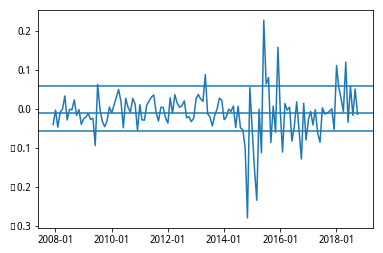

In [17]:
import matplotlib.dates as mdate 

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(list(res.index),list(res.values))

std_deviation = np.std(res)
mean = np.mean(res)

# 设置时间日期格式
ax.xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m'))#设置时间标签显示格式
plt.xticks(pd.date_range(list(res.index)[0],list(res.index)[-1],freq='24M'))  

ax.axhline(std_deviation)
ax.axhline(-std_deviation)
ax.axhline(mean)

plt.show()